In [1]:
import numpy as np
import pandas as pd
import json
import os
import torch
import torch.nn.functional as F
from torch import Tensor, nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertTokenizerFast, BertForSequenceClassification, AdamW
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import nltk
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score

nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /home/tobysavage/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/tobysavage/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# Get the directory you want to list files from
directory = '../../data/BERT'

# List all files and directories in the specified directory
for filename in os.listdir(directory):
    if os.path.isfile(os.path.join(directory, filename)):
        print(filename)


ambig_dev_BERT_full.csv
ambig_train_BERT.csv
ambig_test_BERT.csv
ambig_dev_BERT.csv


In [3]:
df_train = pd.read_csv('../../data/BERT/ambig_train_BERT.csv')
df_train.head()

,ambiguous_question,ambig_class
0,When did the simpsons first air on television?,1
1,Who played george washington in the john adams...,0
2,What is the legal age of marriage in usa?,1
3,Who starred in barefoot in the park on broadway?,1
4,When did the manhattan project began and end?,1


In [4]:
df_dev = pd.read_csv('../../data/BERT/ambig_dev_BERT.csv')
df_dev.head()

,ambiguous_question,ambig_class
0,Which is the eighth planet from the sun (in or...,0
1,Who plays abigail father in the good witch?,0
2,Who is the narrator for the tv show snapped?,1
3,Which is the microsoft hypervisor integrated i...,0
4,Which is the microsoft hypervisor integrated i...,0


In [5]:
df_test = pd.read_csv('../../data/BERT/ambig_test_BERT.csv')
df_test.head()

,ambiguous_question,ambig_class
0,Who plays the doctor in dexter season 1?,0
1,How often does spermatogeneis—the production o...,0
2,How often does spermatogeneis—the production o...,0
3,When was the first remote control tv invented?,0
4,When was the first remote control tv invented?,0


In [6]:
df_dev_full = pd.read_csv('../../data/BERT/ambig_dev_BERT_full.csv')
df_dev_full.head()

,ambiguous_question,ambig_class
0,Who plays the doctor in dexter season 1?,0
1,How often does spermatogeneis—the production o...,0
2,How often does spermatogeneis—the production o...,0
3,When was the first remote control tv invented?,0
4,When was the first remote control tv invented?,0


Model Set Up

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load pre-trained model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.config.dropout = 0.1

# move the model to the GPU
model.to('cuda')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [9]:
inputs_train = list(df_train['ambiguous_question'])
targets_train = list(df_train['ambig_class'])

# Tokenize inputs and targets
inputs_train = tokenizer(inputs_train, padding=True, truncation=True, return_tensors='pt')
targets_train = torch.tensor(targets_train)

In [11]:
print(targets_train.size())

torch.Size([10251])


In [15]:
class AmbigNQDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
        
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item
    
    def __len__(self):
        return len(self.labels)
    
dataset_train = AmbigNQDataset(inputs_train, targets_train)
loader_train = DataLoader(dataset_train, batch_size = 10, shuffle=True)

In [17]:
inputs_dev = list(df_dev['ambiguous_question'])
targets_dev = list(df_dev['ambig_class'])

# Tokenize inputs and targets
inputs_dev = tokenizer(inputs_dev, padding=True, truncation=True, return_tensors='pt')
targets_dev = torch.tensor(targets_dev)
dataset_dev = AmbigNQDataset(inputs_dev, targets_dev)
loader_dev = DataLoader(dataset_dev, batch_size = 10, shuffle = True)

In [20]:
inputs_test = list(df_test['ambiguous_question'])
targets_test = list(df_test['ambig_class'])

# Tokenize inputs and targets
inputs_test = tokenizer(inputs_test, padding=True, truncation=True, return_tensors='pt')
targets_test = torch.tensor(targets_test)
dataset_test = AmbigNQDataset(inputs_test, targets_test)
loader_test = DataLoader(dataset_test, batch_size = 10, shuffle = False)

In [21]:
inputs_dev_full = list(df_dev_full['ambiguous_question'])
targets_dev_full = list(df_dev_full['ambig_class'])

# Tokenize inputs and targets
inputs_dev_full = tokenizer(inputs_dev_full, padding=True, truncation=True, return_tensors='pt')
targets_dev_full = torch.tensor(targets_dev_full)
dataset_dev_full = AmbigNQDataset(inputs_dev_full, targets_dev_full)
loader_dev_full = DataLoader(dataset_dev_full, batch_size = 10, shuffle = True)

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [23]:
# load pre-trained BERT model for fine-tuning
epochs = 5
# model = BartForConditionalGeneration.from_pretrained('facebook/bart-large')

optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)

# Early Stopping Parameters
patience = 2
min_delta = 0.001
best_val_loss = np.inf
patience_counter = 0

training_losses = []
validation_losses = []

# training loop
model.train() # put model in train mode
for epoch in range(epochs):
    total_train_loss = 0
    for batch in loader_train:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to('cuda')
        attention_mask = batch['attention_mask'].to('cuda')
        resultings = batch['labels'].to('cuda')
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=resultings)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        
        total_train_loss +=loss.item()
        
    avg_train_loss = total_train_loss / len(loader_train)
    training_losses.append(avg_train_loss)
    print(f"Epoch: {epoch}, Training Loss: {avg_train_loss}")
    
    
    # Validation Step
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in loader_dev:
            input_ids = batch['input_ids'].to('cuda')
            attention_mask = batch['attention_mask'].to('cuda')
            labels = batch['labels'].to('cuda')
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss/len(loader_dev)
    validation_losses.append(avg_val_loss)
    print(f"Epoch: {epoch}, Validation Loss: {avg_val_loss}")
    
    # Early Stopping Check
    if avg_val_loss + min_delta < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0  # reset counter if improvement is found
    else:
        patience_counter += 1  # increment counter if no improvement

    # Break the loop if patience is exceeded
    if patience_counter >= patience:
        print("Stopping early due to no improvement in validation loss.")
        break
    
    model.train()


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch: 0, Training Loss: 0.6652649442645309
Epoch: 0, Validation Loss: 0.6426373580134058
Epoch: 1, Training Loss: 0.6108907259869993
Epoch: 1, Validation Loss: 0.6370892507663692
Epoch: 2, Training Loss: 0.5121475116406036
Epoch: 2, Validation Loss: 0.663794147950339
Epoch: 3, Training Loss: 0.37521010672321387
Epoch: 3, Validation Loss: 0.793942406055439
Stopping early due to no improvement in validation loss.


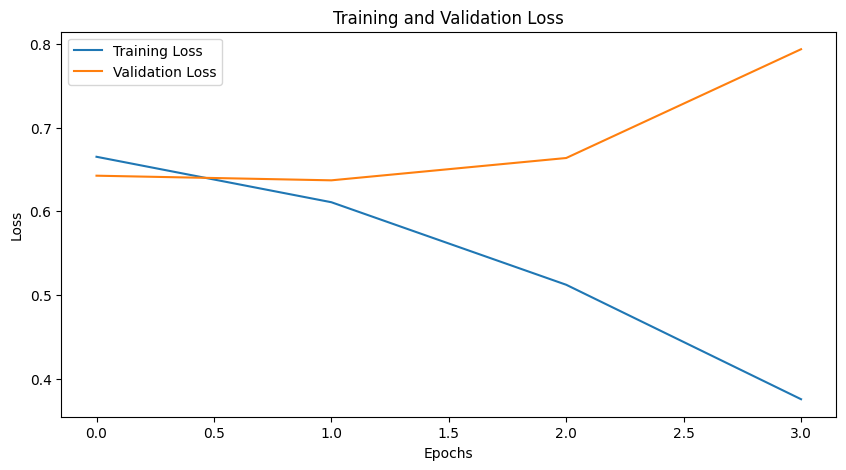

In [24]:
# cpu_training_loss = [loss_item.item() for loss_item in training_losses]

plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss")
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Calculate F1 per epoch or something.